# Customer Segmentation - Clustering

Clustering is a machine learning technique used to group a set of objects in such a way that objects in the same group (or cluster) are more similar to each other than to those in other groups. The goal is to identify inherent structures in data by categorizing similar data points together based on certain criteria or features.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "9"

In [2]:
import pandas as pd
import matplotlib
import seaborn as sns
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [3]:
from matplotlib.colors import ListedColormap
from matplotlib.ticker import PercentFormatter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
data = "../data/ml_project_data_clean.csv"

dfi = pd.read_csv(data)

dfi.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,YearsEnrolled,Age,AgeGroup,MntTotal,MntRegProds,NbChildren,ChildrenPresence,AcceptedCmpTotal,AcceptedSomeCmp,NumTotalPurchases
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,1,57,45-64,1617,1529,0,0,0,0,22
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,0,60,45-64,27,21,2,1,0,0,4
2,Graduation,HasPartner,71613.0,0,0,26,426,49,127,111,...,0,49,45-64,776,734,0,0,0,0,20
3,Graduation,HasPartner,26646.0,1,0,26,11,4,20,10,...,0,30,26-44,53,48,1,1,0,0,6
4,PhD,HasPartner,58293.0,1,0,94,173,43,118,46,...,0,33,26-44,422,407,1,1,0,0,14


In [5]:
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2205 non-null   object 
 1   Marital_Status       2205 non-null   object 
 2   Income               2205 non-null   float64
 3   Kidhome              2205 non-null   int64  
 4   Teenhome             2205 non-null   int64  
 5   Recency              2205 non-null   int64  
 6   MntWines             2205 non-null   int64  
 7   MntFruits            2205 non-null   int64  
 8   MntMeatProducts      2205 non-null   int64  
 9   MntFishProducts      2205 non-null   int64  
 10  MntSweetProducts     2205 non-null   int64  
 11  MntGoldProds         2205 non-null   int64  
 12  NumDealsPurchases    2205 non-null   int64  
 13  NumWebPurchases      2205 non-null   int64  
 14  NumCatalogPurchases  2205 non-null   int64  
 15  NumStorePurchases    2205 non-null   i

# Data Preparation

## Data Transformation

### Exploring Features

In [6]:
# Select columns with numerical data types
num_feat = dfi.select_dtypes(include="number").columns

# Get the number of numerical features
numb_num_feat = len(num_feat)

numb_num_feat

32

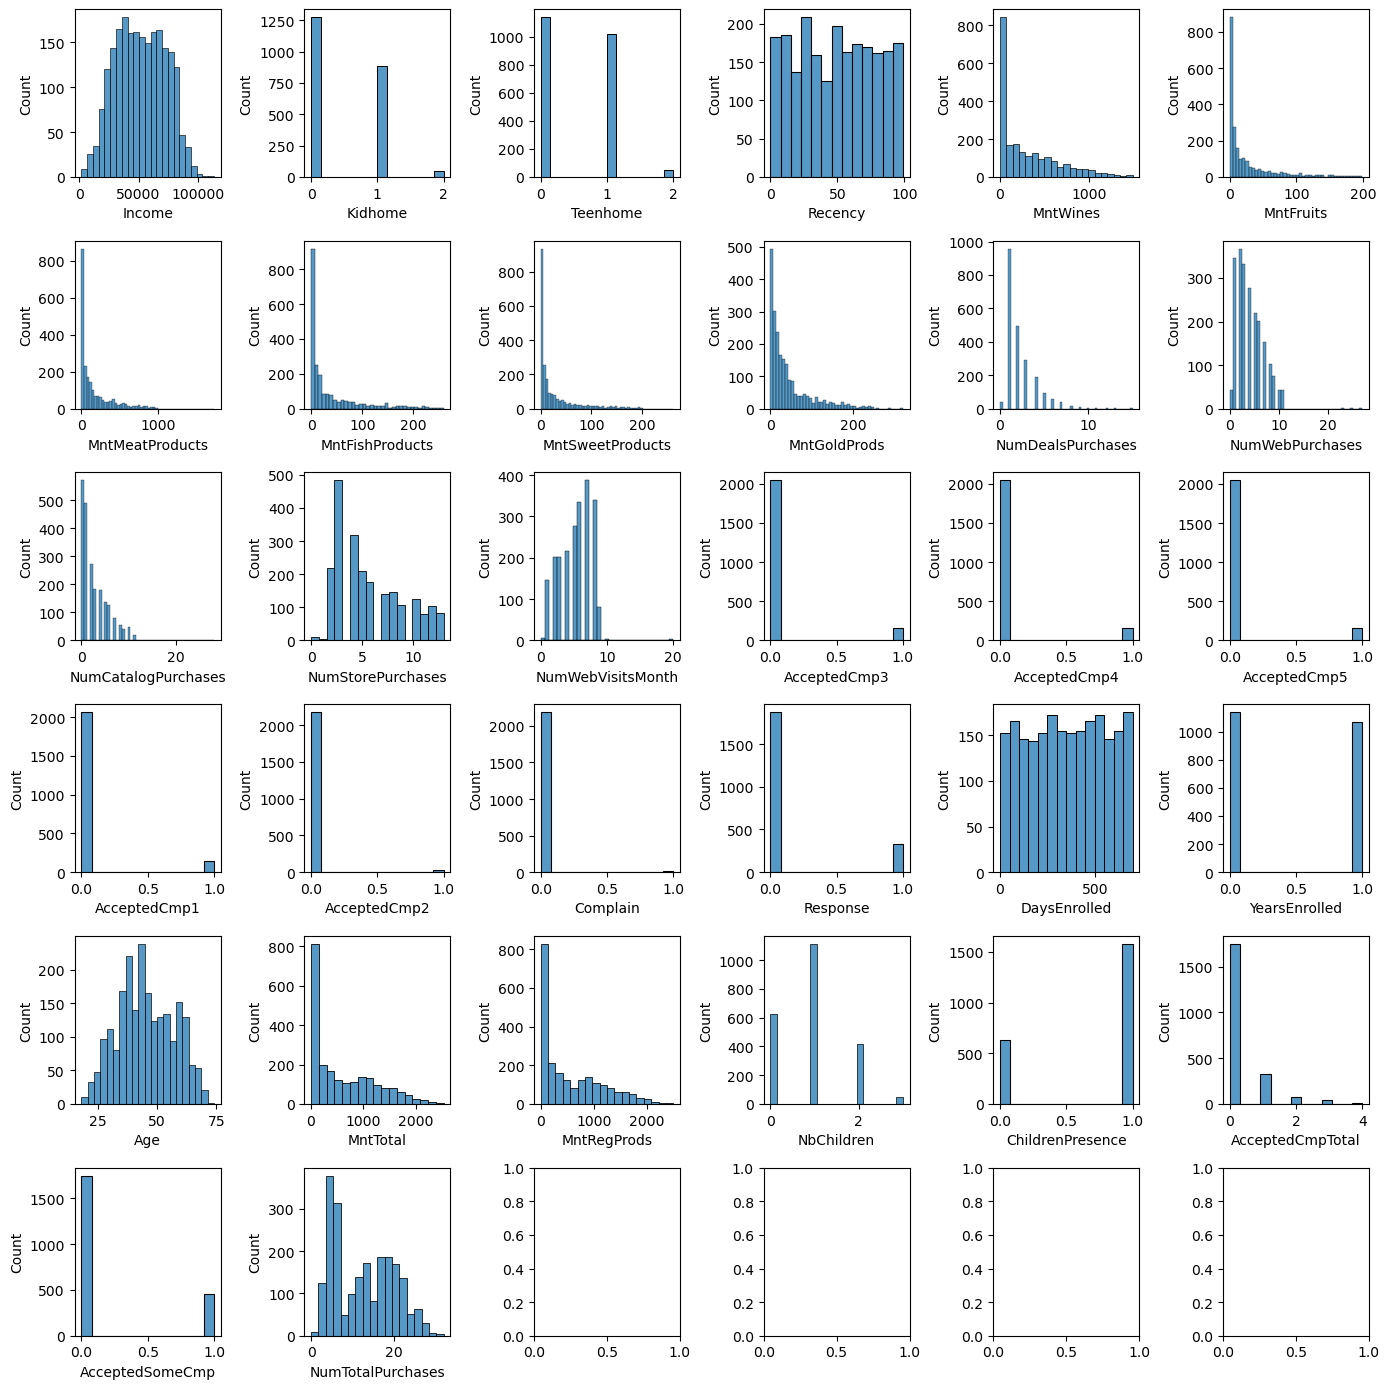

In [7]:
# Create a grid of subplots
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(14, 14), tight_layout=True)

# Flatten the axs array for easy iteration and plot histograms
for ax, feat in zip(axs.flatten(), num_feat):
    sns.histplot(data=dfi, x=feat, ax=ax)

# Remove any remaining empty subplots
for ax in axs[len(num_feat):]:
    fig.delaxes(ax)


plt.show()

### Preprocessing

The transformations in preprocessing were made based on the guidelines in the Scikit-learn documentation: https://scikit-learn.org/stable/api/sklearn.preprocessing.html#module-sklearn.preprocessing

**One-hot Encoding**: This process converts each category value into a new binary column. It is often used for categorical variables where the data does not have a natural order or ranking.

**Standard Scaling**: This transformation standardizes features by removing the mean and scaling to unit variance, which can help improve the performance of many machine learning algorithms.

**Power Transformation**: This technique is used to stabilize variance and make the data more Gaussian-like. It is often applied to features that have a skewed distribution.

**Min-Max Scaling**: This transformation scales features to a fixed range, usually 0 to 1. It preserves the relationships between data points.

In [8]:
onehotenc_cols = [
    "Education",
    "Marital_Status",
    "AgeGroup",
    "ChildrenPresence",
    "AcceptedSomeCmp",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Complain",
    "Response",
    "Kidhome",
    "Teenhome",
    "YearsEnrolled",
    "NbChildren",
    "AcceptedCmpTotal",
]

standardsc_cols = [
    "Income",
    "Age"
]

powertrans_cols = dfi.columns[
    dfi.columns.str.startswith("Mnt") | dfi.columns.str.startswith("Num")
].tolist()

minmaxsc_cols = [
    col for col in dfi.columns if col not in onehotenc_cols + standardsc_cols + powertrans_cols
]

In [9]:
onehotenc_cols

['Education',
 'Marital_Status',
 'AgeGroup',
 'ChildrenPresence',
 'AcceptedSomeCmp',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'Complain',
 'Response',
 'Kidhome',
 'Teenhome',
 'YearsEnrolled',
 'NbChildren',
 'AcceptedCmpTotal']

In [10]:
standardsc_cols

['Income', 'Age']

In [11]:
powertrans_cols

['MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'MntTotal',
 'MntRegProds',
 'NumTotalPurchases']

In [12]:
minmaxsc_cols

['Recency', 'DaysEnrolled']

In [13]:
# Define the column transformer for preprocessing
preprocessing = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(), onehotenc_cols),
        ("standardsc", StandardScaler(), standardsc_cols),
        ("powertrans", PowerTransformer(), powertrans_cols),
        ("minmaxsc", MinMaxScaler(), minmaxsc_cols)
    ]
)

# Apply the transformations to the DataFrame
transformed_data = preprocessing.fit_transform(dfi)

# Retrieve the feature names after transformations
feature_names = preprocessing.get_feature_names_out()

print(feature_names)

['onehot__Education_2n Cycle' 'onehot__Education_Basic'
 'onehot__Education_Graduation' 'onehot__Education_Master'
 'onehot__Education_PhD' 'onehot__Marital_Status_HasPartner'
 'onehot__Marital_Status_Single' 'onehot__AgeGroup_18-25'
 'onehot__AgeGroup_26-44' 'onehot__AgeGroup_45-64' 'onehot__AgeGroup_65+'
 'onehot__ChildrenPresence_0' 'onehot__ChildrenPresence_1'
 'onehot__AcceptedSomeCmp_0' 'onehot__AcceptedSomeCmp_1'
 'onehot__AcceptedCmp1_0' 'onehot__AcceptedCmp1_1'
 'onehot__AcceptedCmp2_0' 'onehot__AcceptedCmp2_1'
 'onehot__AcceptedCmp3_0' 'onehot__AcceptedCmp3_1'
 'onehot__AcceptedCmp4_0' 'onehot__AcceptedCmp4_1'
 'onehot__AcceptedCmp5_0' 'onehot__AcceptedCmp5_1' 'onehot__Complain_0'
 'onehot__Complain_1' 'onehot__Response_0' 'onehot__Response_1'
 'onehot__Kidhome_0' 'onehot__Kidhome_1' 'onehot__Kidhome_2'
 'onehot__Teenhome_0' 'onehot__Teenhome_1' 'onehot__Teenhome_2'
 'onehot__YearsEnrolled_0' 'onehot__YearsEnrolled_1'
 'onehot__NbChildren_0' 'onehot__NbChildren_1' 'onehot__Nb

In [14]:
# Apply the transformations to the DataFrame and create a new DataFrame with transformed data
dfi_transformed = pd.DataFrame(
    preprocessing.fit_transform(dfi),
    columns=preprocessing.get_feature_names_out()
)

dfi_transformed.head()

,onehot__Education_2n Cycle,onehot__Education_Basic,onehot__Education_Graduation,onehot__Education_Master,onehot__Education_PhD,onehot__Marital_Status_HasPartner,onehot__Marital_Status_Single,onehot__AgeGroup_18-25,onehot__AgeGroup_26-44,onehot__AgeGroup_45-64,...,powertrans__NumDealsPurchases,powertrans__NumWebPurchases,powertrans__NumCatalogPurchases,powertrans__NumStorePurchases,powertrans__NumWebVisitsMonth,powertrans__MntTotal,powertrans__MntRegProds,powertrans__NumTotalPurchases,minmaxsc__Recency,minmaxsc__DaysEnrolled
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.753752,1.332973,1.747828,-0.425453,0.700269,1.315543,1.310705,1.221174,0.585859,0.948498
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.160834,-1.382228,-0.384719,-1.473644,-0.108417,-1.447153,-1.453924,-1.319438,0.383838,0.161660
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.838557,1.332973,0.150188,1.239811,-0.527390,0.658507,0.687964,1.025388,0.262626,0.446352
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.160834,-0.726457,-1.341911,-0.425453,0.300240,-1.123214,-1.066232,-0.877589,0.262626,0.198856
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.453779,0.521339,0.518935,0.278071,-0.108417,0.175065,0.238799,0.356875,0.949495,0.230329


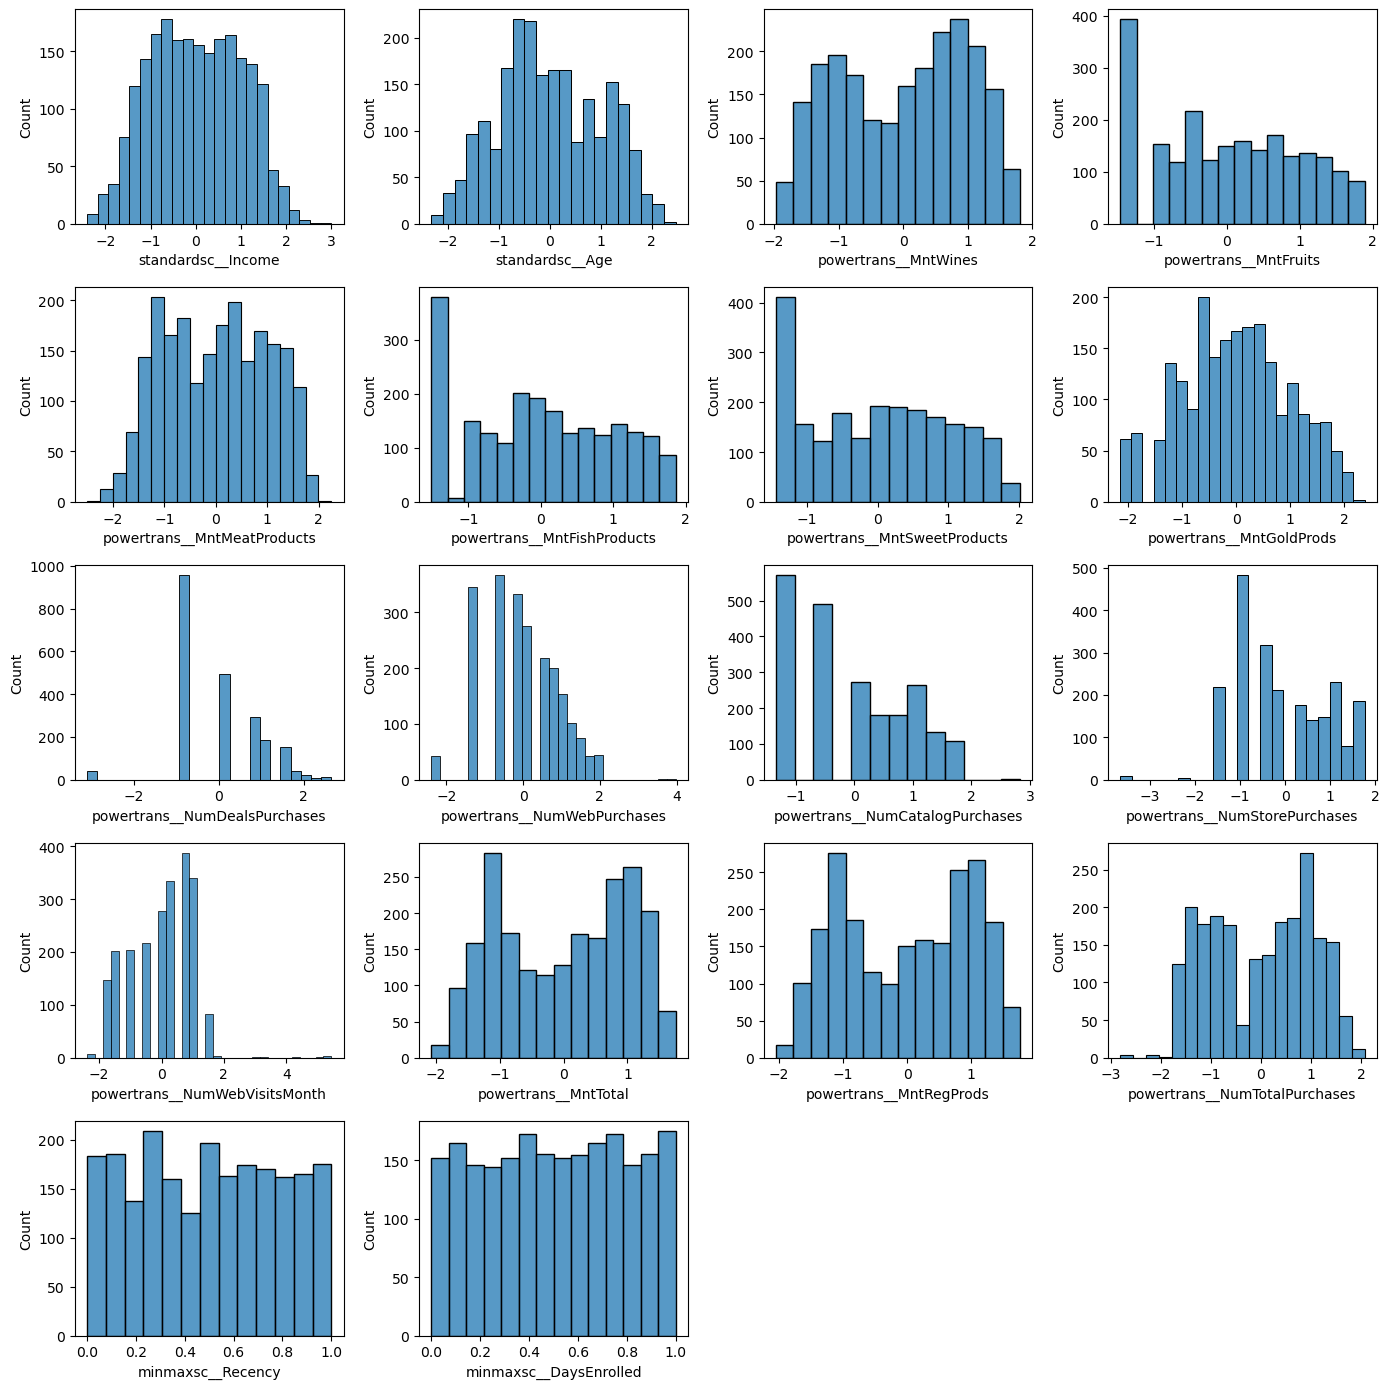

In [15]:
# Select columns that do not start with "onehot"
non_onehot_cols = dfi_transformed.columns[~dfi_transformed.columns.str.startswith("onehot")]

# Create a grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(14, 14), tight_layout=True)

# Flatten the 2D array of axes for easy iteration
axs = axs.flatten()

# Plot histograms for each non-onehot column
for ax, feat in zip(axs, non_onehot_cols):
    sns.histplot(data=dfi_transformed, x=feat, ax=ax)

# Remove any remaining empty subplots
for ax in axs[len(non_onehot_cols):]:
    fig.delaxes(ax)

plt.show()

- The columns created by OneHotEncoder were excluded from the histograms because they represent categorical data, which would not be meaningful in this histogram.
    - StandardScaler has normalized Income and Age to have a mean of zero and unit variance, reducing the influence of outliers and making the data more suitable for algorithms that assume normally distributed data.
    - PowerTransformer has effectively reduced skewness in monetary and purchase features, making the data more Gaussian-like and improving the performance of linear models.
    - MinMaxScaler has scaled features to the range [0, 1], which is essential for distance-based algorithms and ensures that all features contribute equally.

# Modelling

## Select Technique: K-Means

K-Means clustering is a popular and widely used clustering algorithm due to its simplicity, efficiency, and effectiveness in partitioning data into meaningful groups, helping in identifying and understanding the inherent structure and patterns within the data.
- By clustering data into groups, K-Means aids in better understanding and interpreting the dataset, facilitating easier analysis and decision-making.

## Optimal Clusters
**Elbow Method:** To find the optimal number of clusters (k) in K-Means, plot the sum of squared distances (inertia) for different k values. The "elbow point," where the decrease in inertia slows, indicates the best k, balancing between reduced inertia and avoiding overfitting.

**Silhouette Method:** Evaluate clustering quality by calculating the silhouette score, which compares how similar a data point is to its own cluster versus others. The optimal k is where the average silhouette score is highest, showing well-separated, cohesive clusters.

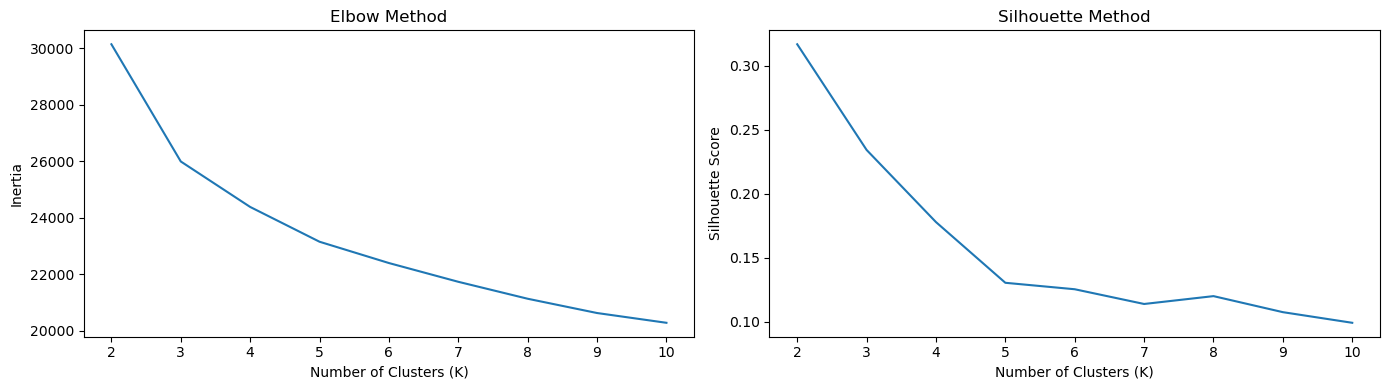

In [16]:
def elbowandsilhouette_plot(X, random_state=42, range_k=(2, 11)):
    """
    Plots the Elbow and Silhouette scores for a range of k values for KMeans clustering.

    Parameters:
    - X: Data to be clustered.
    - random_state: Random state for KMeans.
    - range_k: Tuple indicating the range of k values to evaluate.
    """
    # Create subplots for Elbow and Silhouette methods
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), tight_layout=True)

    # Dictionaries and lists to store inertia and silhouette scores
    inertia_scores = {}
    silhouette_scores = []

    # Range of k values to evaluate
    k_values = range(*range_k)

    for k in k_values:
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(X)

        # Store inertia (Elbow method)
        inertia_scores[k] = kmeans.inertia_

        # Store silhouette score
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(X, labels))

    # Plot Elbow method
    sns.lineplot(x=list(inertia_scores.keys()), y=list(inertia_scores.values()), ax=axs[0])
    axs[0].set_xlabel("Number of Clusters (K)")
    axs[0].set_ylabel("Inertia")
    axs[0].set_title("Elbow Method")

    # Plot Silhouette scores
    sns.lineplot(x=list(k_values), y=silhouette_scores, ax=axs[1])
    axs[1].set_xlabel("Number of Clusters (K)")
    axs[1].set_ylabel("Silhouette Score")
    axs[1].set_title("Silhouette Method")

    # Display the plots
    plt.show()

# Apply the function to the transformed DataFrame
elbowandsilhouette_plot(dfi_transformed)

- Elbow Method suggests that 3 or 4 clusters may offer a good balance, as adding more clusters beyond this point yields minimal improvement in cluster compactness.
- Silhouette Method indicates that 2 clusters provide the most well-defined grouping, with the silhouette score decreasing as more clusters are introduced.
- In practice, selecting 3 clusters could serve as a compromise between the two methods, providing slightly more granularity than 2 clusters while still maintaining relatively well-defined clusters.

## Dimentionality Reduction

In [17]:
# Apply PCA to the transformed DataFrame
pca = PCA(n_components=2)
dfi_pca = pca.fit_transform(dfi_transformed)

dfi_transformed

,onehot__Education_2n Cycle,onehot__Education_Basic,onehot__Education_Graduation,onehot__Education_Master,onehot__Education_PhD,onehot__Marital_Status_HasPartner,onehot__Marital_Status_Single,onehot__AgeGroup_18-25,onehot__AgeGroup_26-44,onehot__AgeGroup_45-64,...,powertrans__NumDealsPurchases,powertrans__NumWebPurchases,powertrans__NumCatalogPurchases,powertrans__NumStorePurchases,powertrans__NumWebVisitsMonth,powertrans__MntTotal,powertrans__MntRegProds,powertrans__NumTotalPurchases,minmaxsc__Recency,minmaxsc__DaysEnrolled
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.753752,1.332973,1.747828,-0.425453,0.700269,1.315543,1.310705,1.221174,0.585859,0.948498
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.160834,-1.382228,-0.384719,-1.473644,-0.108417,-1.447153,-1.453924,-1.319438,0.383838,0.161660
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.838557,1.332973,0.150188,1.239811,-0.527390,0.658507,0.687964,1.025388,0.262626,0.446352
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.160834,-0.726457,-1.341911,-0.425453,0.300240,-1.123214,-1.066232,-0.877589,0.262626,0.198856
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.453779,0.521339,0.518935,0.278071,-0.108417,0.175065,0.238799,0.356875,0.949495,0.230329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.160834,1.554542,0.518935,-0.425453,-0.108417,1.139804,1.017392,0.595707,0.464646,0.545064
2201,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.869090,1.332973,0.150188,-0.045545,0.700269,0.213412,0.289021,0.478618,0.565657,0.027182
2202,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,-0.838557,-0.726457,0.518935,1.760908,0.300240,1.068731,1.109020,0.817607,0.919192,0.221745
2203,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.160834,0.822406,1.023923,1.239811,-0.959114,0.728390,0.738835,1.124668,0.080808,0.223176


## Clustering Pipeline

In [18]:
# Define the random state for reproducibility
RANDOM_STATE = 42

# Create a pipeline with preprocessing, PCA, and KMeans clustering
pipeline = Pipeline([
    ("preprocessing", preprocessing),  # Apply preprocessing steps
    ("pca", PCA(n_components=2, random_state=RANDOM_STATE)),  # Reduce dimensions using PCA
    ("clustering", KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10))  # Apply KMeans clustering
])

# Fit the pipeline to the original DataFrame
pipeline.fit(dfi)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'ChildrenPresence',
                                                   'AcceptedSomeCmp',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2',
                                                   'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5', 'Complain',
                                                   'Response', 'Kidhome',
                                                   'Teenhome', 'YearsEnrolled',
                                                   'NbChildren',
                                                   'AcceptedCmpTotal']),
                                                 ('standardsc'...
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'MntTotal', 'MntRegProds',
                                                   'NumTotalPurchases']),
                                                 ('minmaxsc', MinMaxScaler(),
                                                  ['Recency',
                                                   'DaysEnrolled'])])),
                ('pca', PCA(n_components=2, random_state=42)),
                ('clustering',
                 KMeans(n_clusters=3, n_init=10, random_state=42))])

- By using a pipeline, it is possible to streamline the process of applying multiple transformations and estimators, ensuring that each step is executed in the correct order. This also makes the code more modular and easier to maintain.

# Evaluation

## Clustering Results and Analysis

In [19]:
# Create a copy of the original DataFrame
dfi_clustered = dfi.copy()

# Add the cluster labels from the KMeans clustering to the DataFrame
dfi_clustered["Cluster"] = pipeline.named_steps["clustering"].labels_

dfi_clustered.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegProds,NbChildren,ChildrenPresence,AcceptedCmpTotal,AcceptedSomeCmp,NumTotalPurchases,Cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,45-64,1617,1529,0,0,0,0,22,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,45-64,27,21,2,1,0,0,4,0
2,Graduation,HasPartner,71613.0,0,0,26,426,49,127,111,...,49,45-64,776,734,0,0,0,0,20,1
3,Graduation,HasPartner,26646.0,1,0,26,11,4,20,10,...,30,26-44,53,48,1,1,0,0,6,0
4,PhD,HasPartner,58293.0,1,0,94,173,43,118,46,...,33,26-44,422,407,1,1,0,0,14,2


In [20]:
# Count the number of data points in each cluster and sort the results by cluster index
cluster_counts = dfi_clustered["Cluster"].value_counts().sort_index()

print(cluster_counts)

Cluster
0    888
1    597
2    720
Name: count, dtype: int64


In [21]:
# Define the columns for analysis
analysis_columns = [
    "Income",
    "Recency",
    "DaysEnrolled",
    "Age",
    "MntTotal",
]

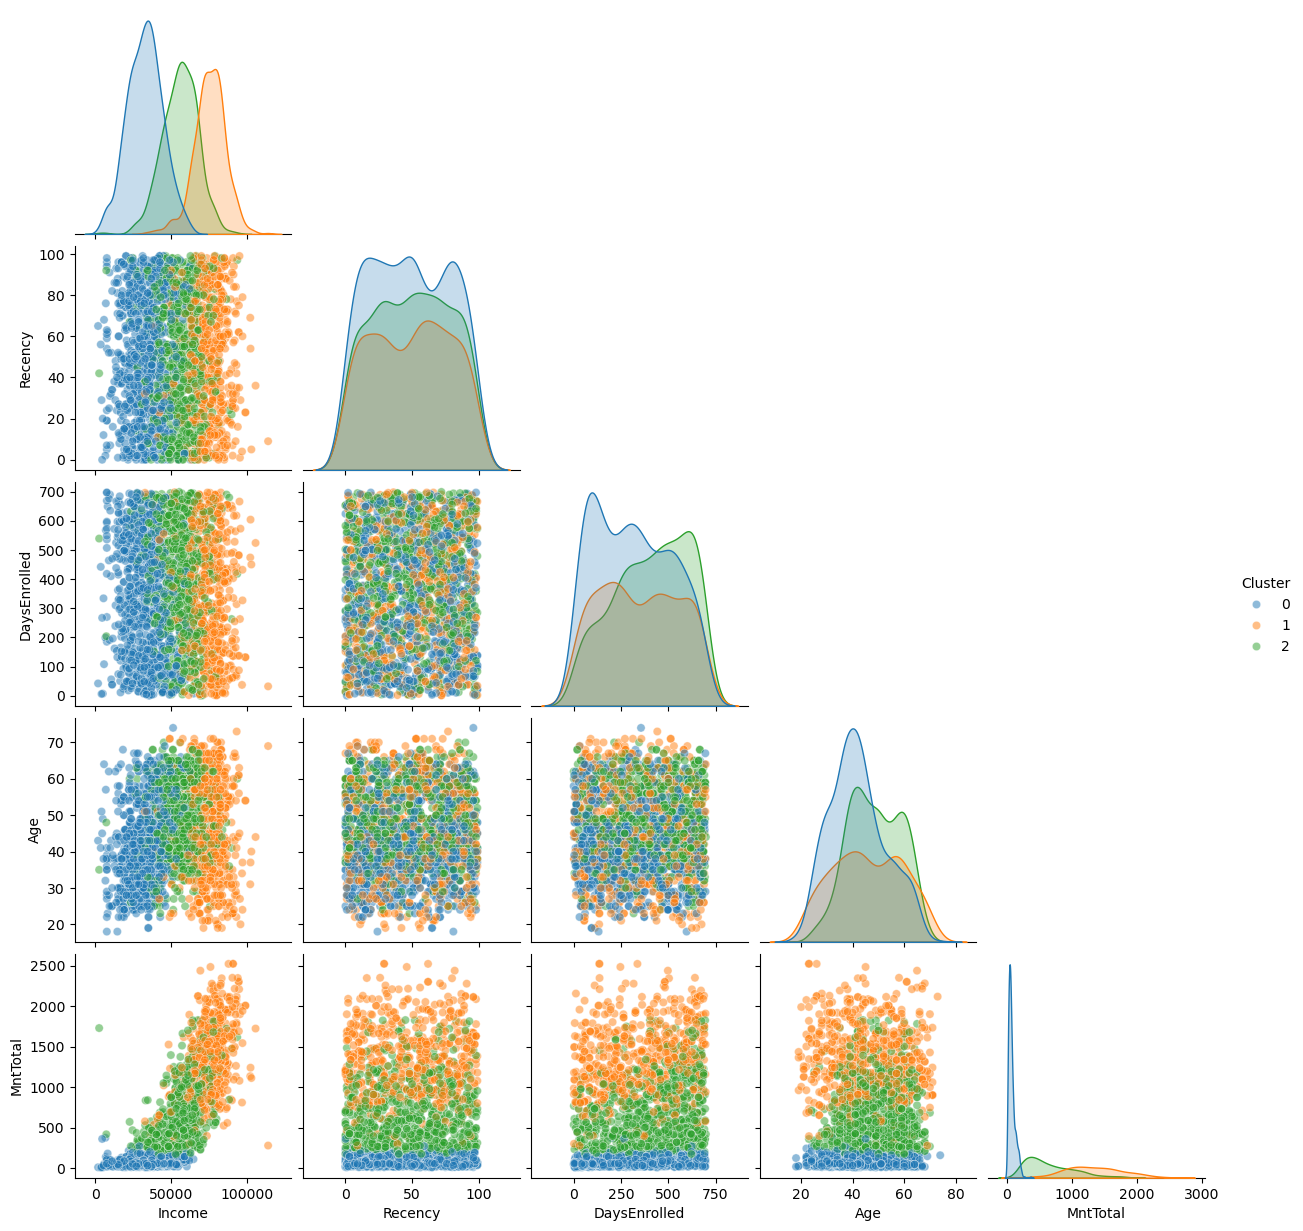

In [22]:
def plot_pairplot(df, cols, hue=None, transparency=0.5, show_upper_triangle=False, color_palette="tab10"):
    """
    Plots a pairplot for the specified columns in the DataFrame with optional hue.

    Parameters:
    - df: The DataFrame containing the data.
    - cols: List of columns to include in the pairplot.
    - hue: Column to use for color coding (optional).
    - transparency: Alpha value for plot points (default is 0.5).
    - show_upper_triangle: If True, shows the upper triangle of the pairplot (default is False).
    - color_palette: Color palette to use for the plot (default is "tab10").
    """
    # Create a list of columns to analyze, including the hue column if provided
    plot_columns = cols.copy()
    if hue:
        plot_columns.append(hue)

    # Plot the pairplot
    sns.pairplot(
        df[plot_columns],
        diag_kind="kde",
        hue=hue,
        plot_kws={'alpha': transparency},
        corner=not show_upper_triangle,
        palette=color_palette
    )

# Call the function to plot the pairplot with clustering results
plot_pairplot(dfi_clustered, analysis_columns, hue="Cluster")

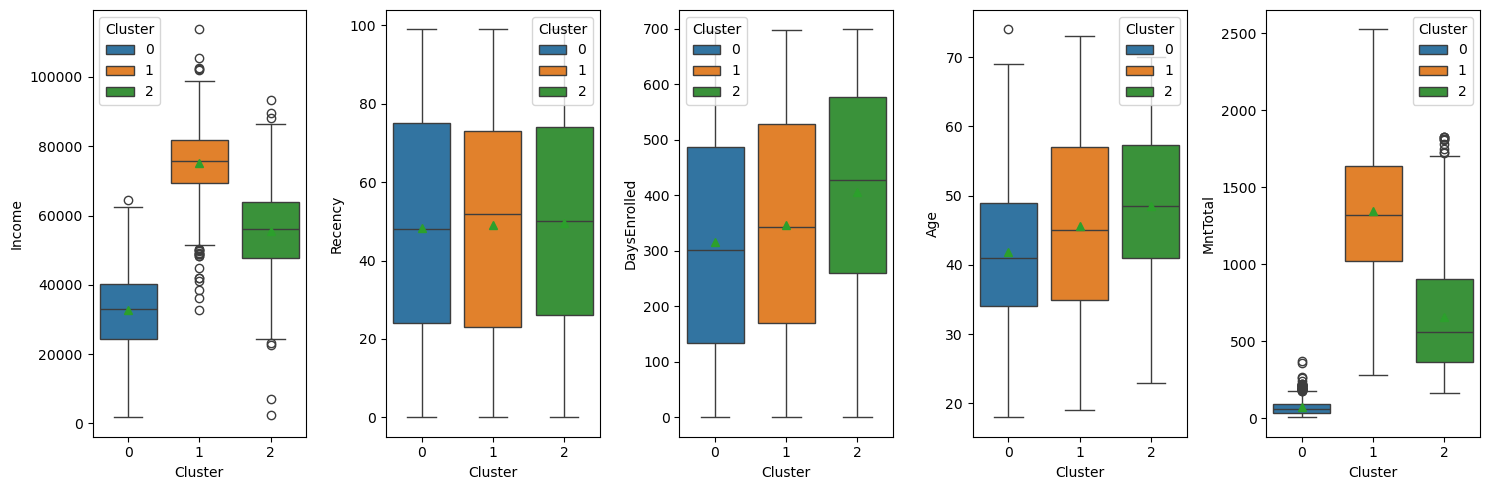

In [23]:
# Create a grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5), tight_layout=True)

# Custom color palette for clusters: blue, orange, green
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Plot boxplots for each specified column
for ax, col in zip(axs, analysis_columns):
    sns.boxplot(x="Cluster", y=col, data=dfi_clustered,ax=ax, showmeans=True, hue="Cluster", palette=custom_palette)

plt.show()

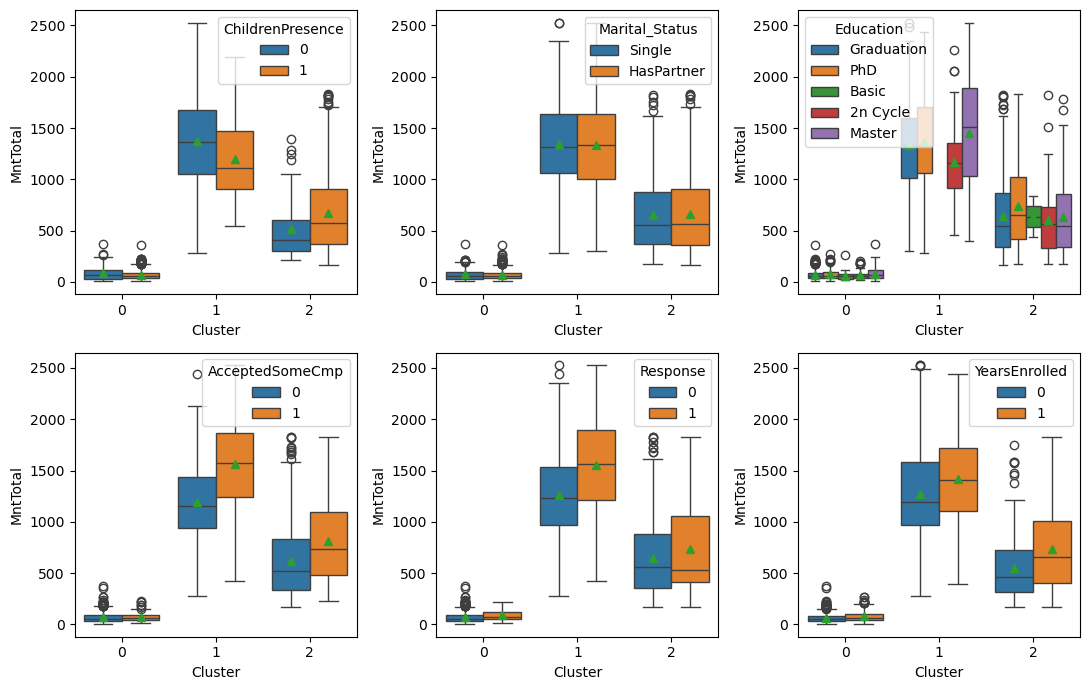

In [24]:
# Define categorical columns and columns for clustering difference analysis
cat_cols = [
    "ChildrenPresence",
    "Marital_Status",
    "Education",
    "AcceptedSomeCmp",
    "Response",
    "YearsEnrolled"
]

cols_diff_clus = ["MntTotal", "Income"]

# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 7), tight_layout=True)

# Plot boxplots analysing Clusters and MntTotal, with different hues for each categorical column
for ax, cat_col in zip(axs.flatten(), cat_cols):
    sns.boxplot(x="Cluster", y=cols_diff_clus[0], data=dfi_clustered, ax=ax, showmeans=True, hue=cat_col)

plt.show()

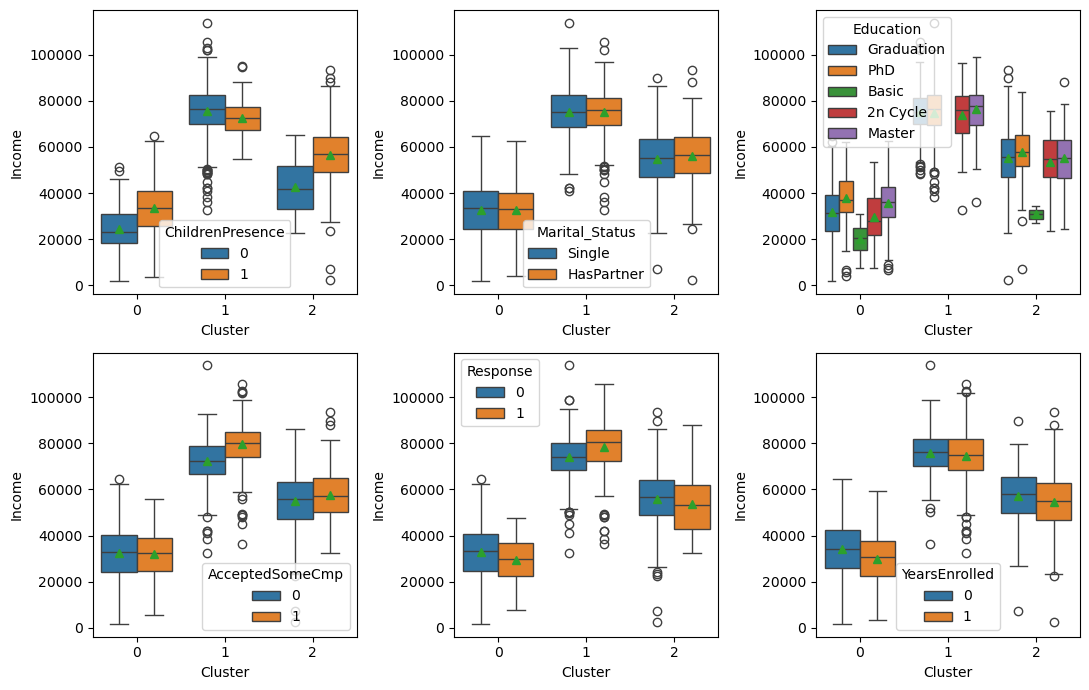

In [25]:
# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 7), tight_layout=True)

# Plot boxplots analysing Clusters and Income, with different hues for each categorical column
for ax, cat_col in zip(axs.flatten(), cat_cols):
    sns.boxplot(x="Cluster", y=cols_diff_clus[1], data=dfi_clustered, ax=ax, showmeans=True, hue=cat_col)

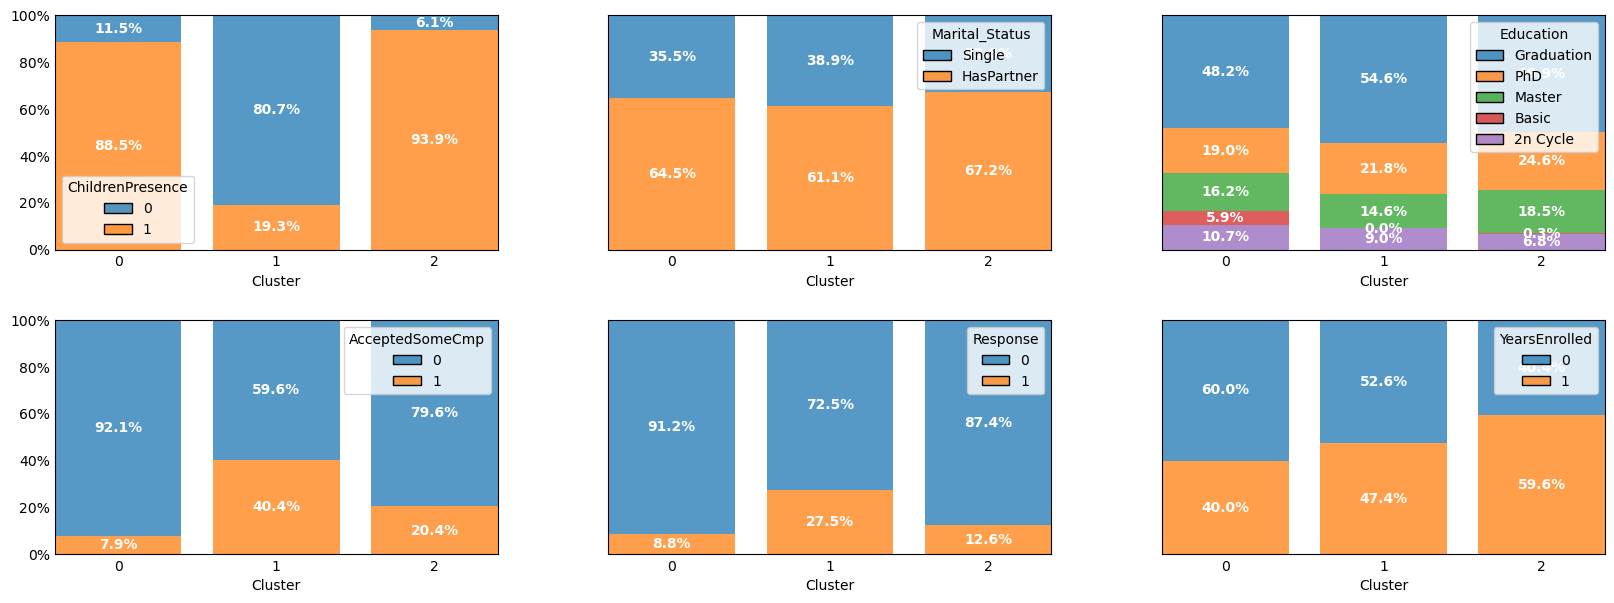

In [26]:
def cols_perc_by_clust(
    dataframe,
    columns,
    grid_shape=(2, 3),
    figsize=(20, 7),
    cluster_col="Cluster",
    palette="tab10"
):
    """
    Plots the percentage distribution of categorical columns by cluster.

    Parameters:
    - dataframe: The DataFrame containing the data.
    - columns: List of categorical columns to plot.
    - grid_shape: Tuple indicating the number of rows and columns in the subplot grid.
    - figsize: Tuple indicating the size of the figure.
    - cluster_col: The column name indicating clusters.
    - palette: Color palette to use for the plots.
    """
    # Create a grid of subplots
    fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=figsize, sharey=True)

    # Ensure axs is an array for consistent iteration
    if not isinstance(axs, np.ndarray):
        axs = np.array(axs)
    
    # Plot each categorical column
    for ax, col in zip(axs.flatten(), columns):
        hist = sns.histplot(
            x=cluster_col, hue=col, data=dataframe, ax=ax,
            multiple="fill", stat="percent", discrete=True, shrink=0.8,
            palette=palette
        )
    
        # Set x-ticks to the number of unique clusters
        n_clusters = dataframe[cluster_col].nunique()
        hist.set_xticks(range(n_clusters))
        hist.yaxis.set_major_formatter(PercentFormatter(1))
        hist.set_ylabel("")
        hist.tick_params(axis="both", which="both", length=0.2)
    
        # Add percentage labels to bars
        for bars in hist.containers:
            hist.bar_label(bars, label_type="center", labels=[f'{b.get_height():.1%}' for b in bars], color="white", weight="bold", fontsize=10)
    
        # Remove bar borders
        for bar in hist.patches:
            bar.set_linewidth(0)
    
    # Adjust subplot spacing
    plt.subplots_adjust(hspace=0.3, wspace=0.25)
    
    # Display the plot
    plt.show()

# Call the function to plot the percentage distribution by cluster
cols_perc_by_clust(dataframe=dfi_clustered, columns=cat_cols)

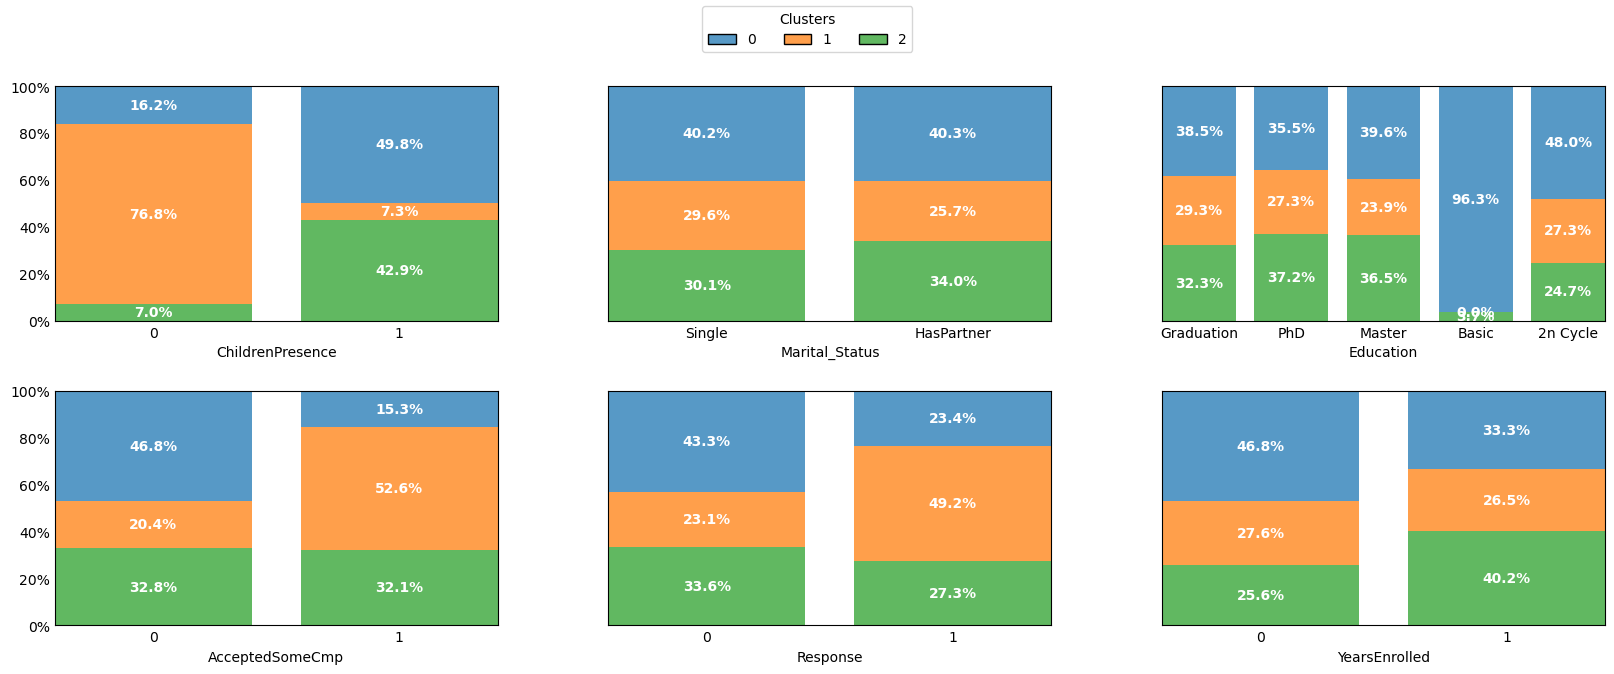

In [27]:
def cols_perc_hue_clust(
    dataframe,
    columns,
    grid_shape=(2, 3),
    figsize=(20, 7),
    cluster_col="Cluster",
    palette="tab10"
):
    """
    Plots the percentage distribution of clusters for each categorical column selected.

    Parameters: the same as the function above
    """
    # Create a grid of subplots
    fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=figsize, sharey=True)

    # Ensure axs is an array for consistent iteration
    if not isinstance(axs, np.ndarray):
        axs = np.array(axs)
    
    # Plot each column with cluster as hue
    for ax, col in zip(axs.flatten(), columns):
        hist = sns.histplot(
            x=col, hue=cluster_col, data=dataframe, ax=ax,
            multiple="fill", stat="percent", discrete=True, shrink=0.8,
            palette=palette
        )
    
        # Set x-ticks for non-object columns
        if dataframe[col].dtype != "object":
            hist.set_xticks(range(dataframe[col].nunique()))
    
        # Format y-axis as percentages
        hist.yaxis.set_major_formatter(PercentFormatter(1))
        hist.set_ylabel("")
        hist.tick_params(axis="both", which="both", length=0.2)
        
        # Add percentage labels to bars
        for bars in hist.containers:
            hist.bar_label(bars, label_type="center", labels=[f'{b.get_height():.1%}' for b in bars], color="white", weight="bold", fontsize=10)
        
        # Remove bar borders
        for bar in hist.patches:
            bar.set_linewidth(0)
    
        # Remove legend from individual plots
        legend = hist.get_legend()
        if legend:
            legend.remove()
    
    # Add a single legend to the figure
    labels = [text.get_text() for text in legend.get_texts()]
    fig.legend(handles=legend.legend_handles, labels=labels, loc="upper center", ncols=dataframe[cluster_col].nunique(), title="Clusters")
        
    # Adjust subplot spacing
    plt.subplots_adjust(hspace=0.3, wspace=0.25)
    
    # Display the plot
    plt.show()

# Call the function to plot the percentage distribution of clusters for each categorical column selected
cols_perc_hue_clust(dataframe=dfi_clustered, columns=cat_cols)

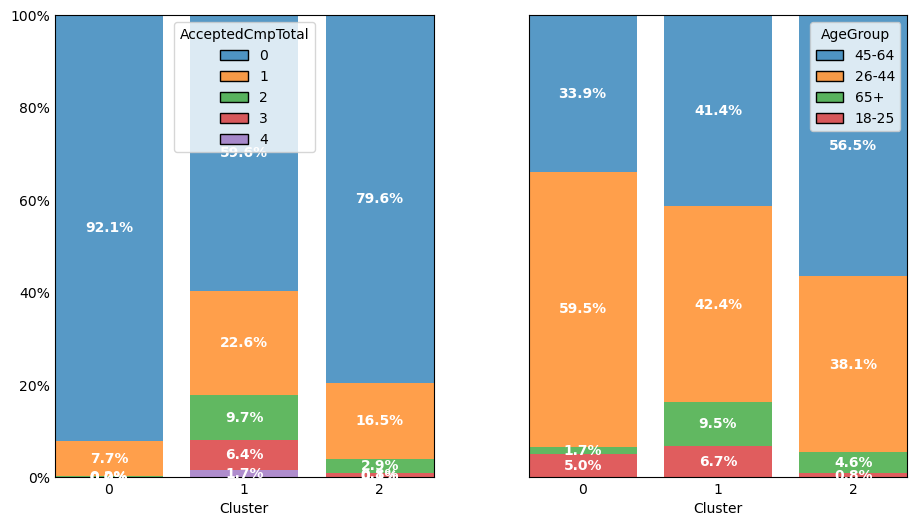

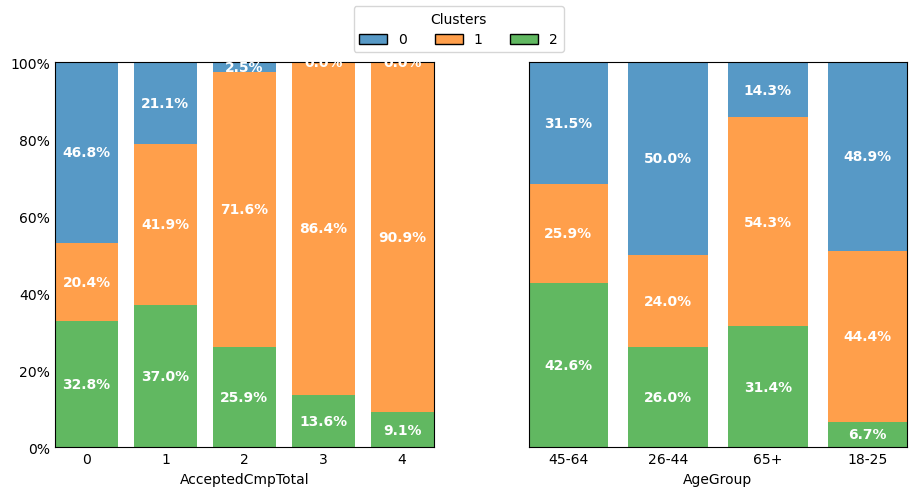

In [28]:
cols_perc_by_clust(
    dataframe=dfi_clustered,
    columns=["AcceptedCmpTotal", "AgeGroup"],
    grid_shape=(1, 2),
    figsize=(11, 6)
)

cols_perc_hue_clust(
    dataframe=dfi_clustered,
    columns=["AcceptedCmpTotal", "AgeGroup"],
    grid_shape=(1, 2),
    figsize=(11, 5)
)

Based on the visualizations, it is possible to highligh some cluster characteristics:

Cluster 0:
- Income: Low income with a median around 30,000.
- Recency: Almost no difference compared to other clusters.
- Days Enrolled: More recent customers in the company database, with an evident peak in people that have fewer days since enrollment.
- Age: Predominantly younger people, including adults and middle-aged adults. 48.9% of young adults are in this cluster.
- MntTotal: Low spending, with most customers spending less than 500.
- ChildrenPresence: High percentage (88.5%) of customers have children.
- Marital Status: Similar distribution across all clusters.
- Education: Majority (96.3%) of people with basic education are in this cluster.
- AcceptedCmp: Very low acceptance of campaigns (7.9%). Almost half of the people who never accepted any campaign are in this cluster.
- Response: Moderate-low response rate to marketing (23.4% of those who responded are from this cluster).

Cluster 1:
- Income: Highest income range with a median around 70,000.
- Recency: Almost no difference compared to other clusters.
- Days Enrolled: Distribution of days enrolled without a specific peak, covering a broad range.
- Age: People of all ages, without a standout age profile. However, 54.3% of older adults are in this cluster.
- MntTotal: Highest spending, with many customers spending between 100 and 1600.
- ChildrenPresence: Most probably do not have children (80.7% do not have children).
- Marital Status: Similar distribution across all clusters.
- Education: Cluster without people with low education levels.
- AcceptedCmp: High propensity to accept campaigns. 52.6% of people who have accepted at least one campaign are in this cluster.
- Response: High response rate (49.2% of those who responded are from this cluster).

Cluster 2:
- Income: Mid-range income with a median around 50,000.
- Recency: Almost no difference compared to other clusters.
- Days Enrolled: Customers have been enrolled for a longer time, with a peak in people with more days enrolled.
- Age: Predominantly middle-aged adults and adults.
- MntTotal: Intermediate spending, with most customers spending between 500 and 1000.
- ChildrenPresence: Majority have children (93.9%).
- Marital Status: Similar distribution across all clusters.
- Education: Higher education levels (PhD, Master's).
- AcceptedCmp: Moderate propensity to accept campaigns, neither high nor low.
- Response: Moderate-high response rate (27.3% of those who responded are from this cluster).

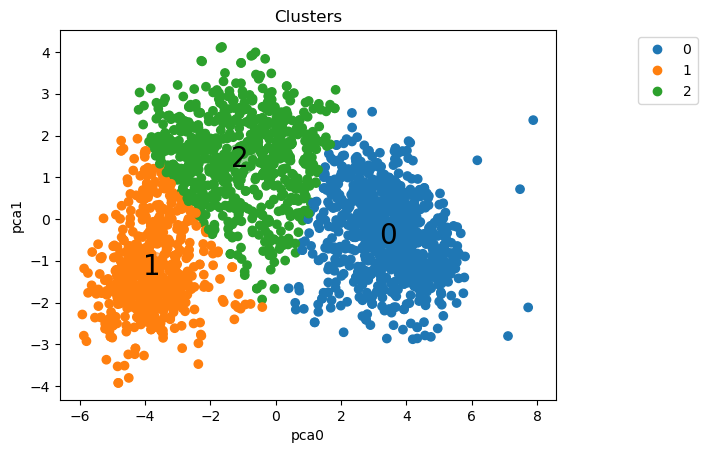

In [29]:
# Apply the pipeline (excluding the clustering step) to transform the DataFrame
transformed_data = pipeline[:-1].fit_transform(dfi)
dfi_pca = pd.DataFrame(
    transformed_data,
    columns=pipeline[:-1].get_feature_names_out()
)

# Retrieve the cluster centroids from the KMeans clustering step
centroids = pipeline["clustering"].cluster_centers_

# Function to plot clusters in 2D
def plot_2D_clusters(
    dataframe,
    columns,
    num_colors,
    centroids,
    show_centroids=True,
    show_points=False,
    cluster_labels=None,
):
    """
    Plots clusters in a 2D scatter plot.

    Parameters:
    - dataframe: The DataFrame containing the transformed data.
    - columns: The columns to use for the x and y axes.
    - num_colors: Number of colors to use for the clusters.
    - centroids: The cluster centroids.
    - show_centroids: Whether to show the centroids in the plot (default is True).
    - show_points: Whether to show the data points in the plot (default is False).
    - cluster_labels: The column with cluster labels for each data point (default is None).
    """
    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Define colors for clusters using a colormap
    colors = plt.cm.tab10.colors[:num_colors]
    colormap = ListedColormap(colors)

    # Extract x and y data based on specified columns
    x = dataframe[columns[0]]
    y = dataframe[columns[1]]

    # Plot centroids if specified
    if show_centroids:
        for i, centroid in enumerate(centroids):
            ax.scatter(*centroid, s=500, alpha=0.5)
            ax.text(
                *centroid,
                f"{i}",
                fontsize=20,
                ha="center",
                va="center"
            )

    # Plot data points if specified
    if show_points and cluster_labels is not None:
        scatter = ax.scatter(x, y, c=cluster_labels, cmap=colormap)
        # Add a legend for the data points
        ax.legend(*scatter.legend_elements(), bbox_to_anchor=(1.3, 1))

    # Set labels for x and y axes
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    # Set the title of the plot
    ax.set_title("Clusters")

    # Display the plot
    plt.show()

# Call the function to plot the clusters in 2D
plot_2D_clusters(
    dataframe=dfi_pca,
    columns=dfi_pca.columns,
    num_colors=3,
    centroids=centroids,
    show_points=True,
    cluster_labels=dfi_clustered["Cluster"]
)

The visualization demonstrates that the clusters are clearly defined, with three distinct, well-separated regions and no overlap between clusters. This indicates that the clustering step effectively identified the clusters.

## Saving the Clustered Dataset

In [30]:
dfi_clustered.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegProds,NbChildren,ChildrenPresence,AcceptedCmpTotal,AcceptedSomeCmp,NumTotalPurchases,Cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,45-64,1617,1529,0,0,0,0,22,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,45-64,27,21,2,1,0,0,4,0
2,Graduation,HasPartner,71613.0,0,0,26,426,49,127,111,...,49,45-64,776,734,0,0,0,0,20,1
3,Graduation,HasPartner,26646.0,1,0,26,11,4,20,10,...,30,26-44,53,48,1,1,0,0,6,0
4,PhD,HasPartner,58293.0,1,0,94,173,43,118,46,...,33,26-44,422,407,1,1,0,0,14,2


In [31]:
dfi_clustered.to_csv("../data/ml_project_data_clust.csv", index=False)